## Loading Libraries

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
import os

## Importing our Helper Functions from Utils

In [2]:
from utils.DatasetHelper import *
from utils.ModelHelper import *
from utils.PlotHelper import *

In [3]:
def predict_with_euclidean_distance(X_train, y_train, X_test):
    print("X_Test lenght: ", len(X_test))
    predictions = []
    counter = 0
    for test_sample in X_test:
        counter += 1
        if counter % 100 == 0:
            print("%", counter / len(X_test) * 100)
        distances = [euclidean_distance(
            test_sample, train_sample) for train_sample in X_train]
        min_index = np.argmin(distances)
        predictions.append(y_train[min_index])
    return predictions

In [4]:
def apply_sklearn_PCA(X_train, X_test, y_train, param=default_params):
    pca, X_train_pca, X_test_pca = sklearn_PCA(X_train, X_test, param)
    predictions = predict_with_euclidean_distance(
        X_train_pca, y_train, X_test_pca)
    return predictions

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

default_params = {'n_components': 150, 'svd_solver': 'auto',
                          'iterated_power': 7, 'random_state': 42}


def sklearn_PCA(X_train, X_test, param=default_params):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    pca = PCA(n_components=param['n_components'],
              svd_solver=param['svd_solver'],
              iterated_power=param['iterated_power'],
              random_state=param['random_state'])
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    return pca, scaler, X_train_pca, X_test_pca


#### Bottom Functions Used to Manuplate Datasets

In [ ]:
# dataset1_path = '../../../../Data/fer2013'
# dataset2_path = '../../../../Data/ExpW-F-Preprocessed'
# merged_dataset_path = '../../../../Data/merged'

# merge_datasets(dataset1_path, dataset2_path, merged_dataset_path)

# source_folder = '../../../../Data/ExpW-F-Preprocessed_100x100'
# train_folder = '../../../../Data/ExpW-F-Preprocessed_100x100/train'
# validation_folder = '../../../../Data/ExpW-F-Preprocessed_100x100/validation'

# split_data(source_folder, train_folder, validation_folder, test_size=0.2)

## Preparing Dataset

In [5]:
def load_images_from_folder(folder, max_images_per_class=None, flatten=False):
    images = []
    labels = []
    for label_folder in os.listdir(folder):
        label_folder_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_folder_path):
            count_images_for_class = 0
            print("label_folder_path: ", label_folder_path)
            for image_file in os.listdir(label_folder_path):
                if max_images_per_class is not None and count_images_for_class >= max_images_per_class:
                    print(f"Reached maximum number of images for class {label_folder}. Skipping the rest.")
                    break
                count_images_for_class += 1
                image_path = os.path.join(label_folder_path, image_file)
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (48, 48))
                if flatten:
                    img = img.flatten()
                images.append(img)
                labels.append(label_folder)
    return np.array(images), np.array(labels)

In [6]:
def prepare_X_y_from_two_folder(path_train, path_validation, max_images_per_class=None, flatten=False):
    images_train, labels_train = load_images_from_folder(path_train, max_images_per_class, flatten=flatten)
    images_test, labels_test = load_images_from_folder(path_validation, max_images_per_class, flatten=flatten)
    X = np.concatenate((images_train, images_test), axis=0)
    y = np.concatenate((labels_train, labels_test), axis=0)
    return X, y

def prepare_X_y_from_one_folder(path, max_images_per_class=None, flatten=False):
    images, labels = load_images_from_folder(path, max_images_per_class, flatten=flatten)
    return images, labels


## Using Fer-2013 Dataset

In [11]:
train_folder = '../../../../Data/fer2013/train'
test_folder = '../../../../Data/fer2013/validation'

X, y = prepare_X_y_from_two_folder(train_folder, test_folder, max_images_per_class=500, flatten=False)

label_folder_path:  ../../../../Data/fer2013/train/happy
Reached maximum number of images for class happy. Skipping the rest.
label_folder_path:  ../../../../Data/fer2013/train/sad
Reached maximum number of images for class sad. Skipping the rest.
label_folder_path:  ../../../../Data/fer2013/train/fear
Reached maximum number of images for class fear. Skipping the rest.
label_folder_path:  ../../../../Data/fer2013/train/surprise
Reached maximum number of images for class surprise. Skipping the rest.
label_folder_path:  ../../../../Data/fer2013/train/neutral
Reached maximum number of images for class neutral. Skipping the rest.
label_folder_path:  ../../../../Data/fer2013/train/angry
Reached maximum number of images for class angry. Skipping the rest.
label_folder_path:  ../../../../Data/fer2013/train/disgust
label_folder_path:  ../../../../Data/fer2013/validation/happy
Reached maximum number of images for class happy. Skipping the rest.
label_folder_path:  ../../../../Data/fer2013/valid

## Using Exp-W Dataset

In [ ]:
train_folder = '../../../../Data/ExpW-F-Preprocessed/train'
test_folder = '../../../../Data/ExpW-F-Preprocessed/validation'

X, y = prepare_X_y_from_two_folder(train_folder, test_folder, max_images_per_class=500, flatten=False)

## Using Both Datasets

In [ ]:
train_folder = '../../../../Data/merged/train'
test_folder = '../../../../Data/merged/validation'

X, y = prepare_X_y_from_two_folder(train_folder, test_folder, max_images_per_class=500, flatten=False)

# Dataset Is Ready 
# ____________________

## Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Extract Features with LBP

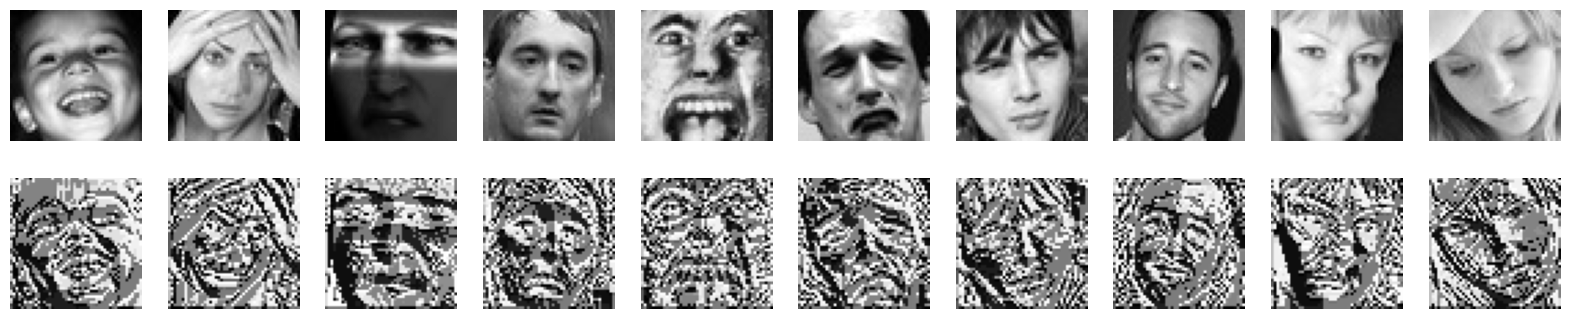

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def LBP(image, num_points, radius):
    lbp = np.zeros_like(image, dtype=np.uint8)
    for i in range(len(image)):
        for j in range(len(image[0])):
            center = image[i, j]
            lbp_code = 0
            for k in range(num_points):
                theta = 2 * np.pi * k / num_points
                x = int(j + radius * np.cos(theta))
                y = int(i - radius * np.sin(theta))
                if x >= 0 and x < len(image[0]) and y >= 0 and y < len(image):
                    if image[y, x] >= center:
                        lbp_code |= (1 << k)
            lbp[i, j] = lbp_code
    return lbp

images = X_train[:10]

num_points = 8
radius = 1

lbp_images = []
for image in images:
    lbp_image = LBP(image, num_points, radius)
    lbp_images.append(lbp_image)
    
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

for i, ax in enumerate(axes[0]):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')

for i, ax in enumerate(axes[1]):
    ax.imshow(lbp_images[i], cmap='gray')
    ax.axis('off')

plt.show()


In [ ]:
num_points_parameters = [4, 8, 16, 24, 32]
radius_parameters = [1, 2, 3]

In [ ]:
for num_points in num_points_parameters:
    for radius in radius_parameters:
        X_train_lbp = np.array([LBP(image, num_points, radius) for image in X_train])
        X_test_lbp = np.array([LBP(image, num_points, radius) for image in X_test])
        X_train_lbp_flat = np.array([lbp.flatten() for lbp in X_train_lbp])
        X_test_lbp_flat = np.array([lbp.flatten() for lbp in X_test_lbp])

        predictions_with_lbp_pca = apply_sklearn_PCA(X_train_lbp_flat, X_test_lbp_flat, y_train)
        
        plot_label_accuracies(np.array(predictions_with_lbp_pca), np.array(y_test), f"{num_points}_{radius}_LBP_PCA")

In [15]:
num_points = 32
radius = 3

X_train_lbp = np.array([LBP(image, num_points, radius) for image in X_train])
X_test_lbp = np.array([LBP(image, num_points, radius) for image in X_test])
X_train_lbp_flat = np.array([lbp.flatten() for lbp in X_train_lbp])
X_test_lbp_flat = np.array([lbp.flatten() for lbp in X_test_lbp])

In [24]:
pca_loaded, scaler_loaded, X_train_pca, X_test_pca = sklearn_PCA(X_train_lbp_flat, X_test_lbp_flat)

In [25]:
import joblib
joblib.dump(pca_loaded, 'lbp_pca_model.pkl')
joblib.dump(scaler_loaded, 'lbp_pca_scaler.pkl')
np.save('X_train_pca.npy', X_train_pca)
np.save('y_train.npy', y_train)

X_Test lenght:  655
% 15.267175572519085
% 30.53435114503817
% 45.80152671755725
% 61.06870229007634
% 76.33587786259542
% 91.6030534351145


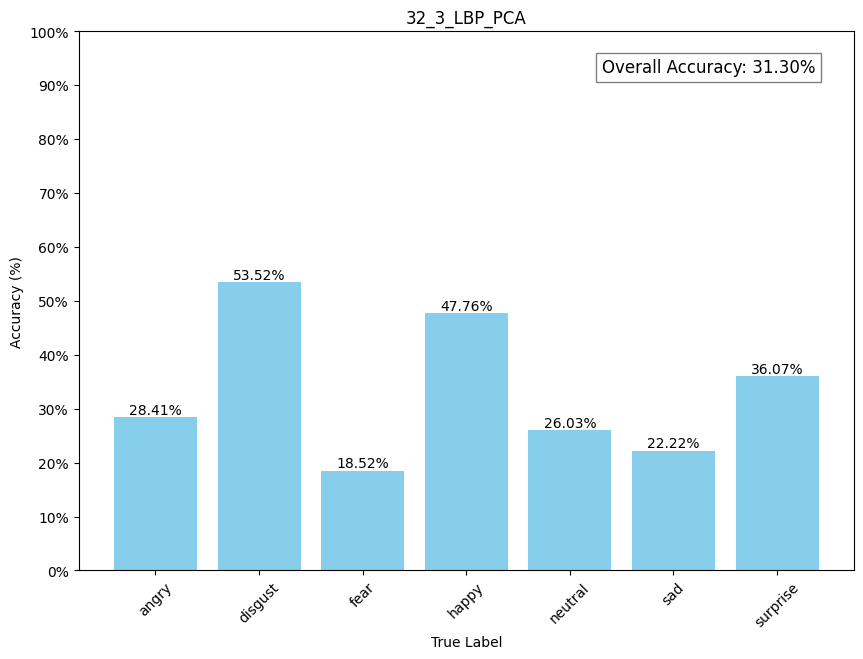

In [18]:
predictions_with_lbp_pca = predict_with_euclidean_distance(X_train_pca, y_train, X_test_pca)

plot_label_accuracies(np.array(predictions_with_lbp_pca), np.array(y_test), f"{num_points}_{radius}_LBP_PCA")

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns;

f1_score = f1_score(np.array(predictions_with_lbp_pca), np.array(y_test), average='weighted')
print("f1_score = ", f1_score)
confusion_matrix = confusion_matrix(np.array(predictions_with_lbp_pca), np.array(y_test))

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Confusion Matrisi')
plt.show()

In [ ]:
num_points = 32
radius = 3

X_train_lbp = np.array([LBP(image, num_points, radius) for image in X_train])
X_test_lbp = np.array([LBP(image, num_points, radius) for image in X_test])
X_train_lbp_flat = np.array([lbp.flatten() for lbp in X_train_lbp])
X_test_lbp_flat = np.array([lbp.flatten() for lbp in X_test_lbp])

predictions_with_lbp_pca = apply_manuel_PCA(X_train_lbp_flat, X_test_lbp_flat, y_train)

plot_label_accuracies(np.array(predictions_with_lbp_pca), np.array(y_test), f"{num_points}_{radius}_LBP_ManuelPCA")

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns;

f1_score = f1_score(np.array(predictions_with_lbp_pca), np.array(y_test), average='weighted')
print("f1_score = ", f1_score)
confusion_matrix = confusion_matrix(np.array(predictions_with_lbp_pca), np.array(y_test))

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Confusion Matrisi')
plt.show()

## See examples from Image Sample

label_folder_path:  ../ImageSample/happy
Reached maximum number of images for class happy. Skipping the rest.
label_folder_path:  ../ImageSample/sad
label_folder_path:  ../ImageSample/fear
label_folder_path:  ../ImageSample/surprise
label_folder_path:  ../ImageSample/neutral
label_folder_path:  ../ImageSample/angry
Reached maximum number of images for class angry. Skipping the rest.
label_folder_path:  ../ImageSample/disgust


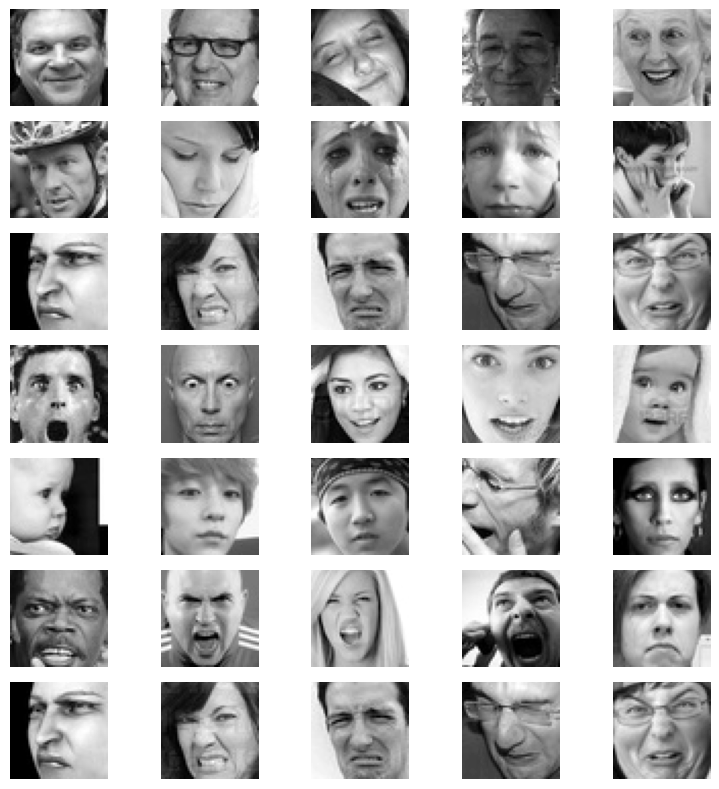

In [30]:
path_samle = '../ImageSample'
images_small, labels_small = load_images_from_folder(path_samle, max_images_per_class = 5, flatten=False)

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(8, 8))

for row_num, row_ax in enumerate(axes):

    for i, ax in enumerate(row_ax):
        image_index = 5 * row_num + i
        
        if image_index >= len(images_small):
            break

        ax.imshow(images_small[image_index], cmap='gray')
        ax.axis('off')

plt.tight_layout()
plt.show()



In [26]:
num_points = 32
radius = 3

X_test_lbp = np.array([LBP(image, num_points, radius) for image in images_small])
X_train_lbp = np.array([LBP(image, num_points, radius) for image in X_train])
X_test_lbp_flat = np.array([lbp.flatten() for lbp in X_test_lbp])
X_train_lbp_flat = np.array([lbp.flatten() for lbp in X_train_lbp])

preds_small = apply_manuel_PCA(X_train_lbp_flat, X_test_lbp_flat, y_train)

# in the below cell you can see the results of predicstions in an array

X_Test lenght:  35


['angry',
 'happy',
 'sad',
 'sad',
 'happy',
 'disgust',
 'neutral',
 'angry',
 'sad',
 'surprise',
 'disgust',
 'disgust',
 'disgust',
 'happy',
 'disgust',
 'surprise',
 'disgust',
 'surprise',
 'angry',
 'surprise',
 'neutral',
 'surprise',
 'neutral',
 'happy',
 'neutral',
 'neutral',
 'neutral',
 'surprise',
 'happy',
 'surprise',
 'disgust',
 'disgust',
 'disgust',
 'happy',
 'disgust']

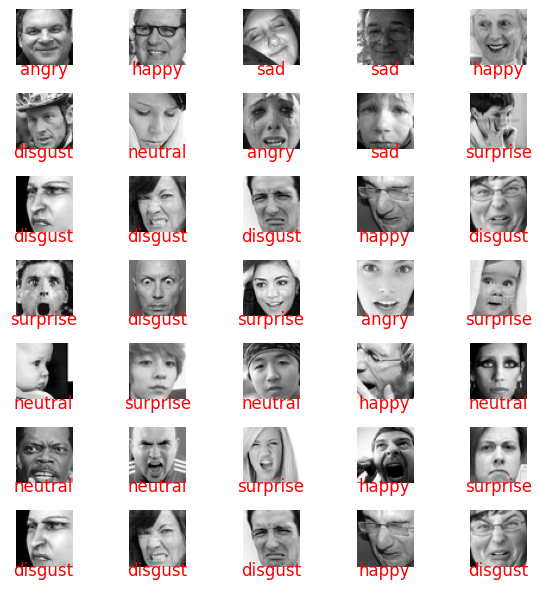

In [32]:
# preds_small = ['angry', 'happy', 'sad', 'sad', 'happy', 'disgust', 'neutral', 'angry', 'sad', 'surprise', 'disgust', 'disgust', 'disgust', 'happy', 'disgust', 'surprise', 'disgust', 'surprise', 'angry', 'surprise', 'neutral', 'surprise', 'neutral', 'happy', 'neutral', 'neutral', 'neutral', 'surprise', 'happy', 'surprise', 'disgust', 'disgust', 'disgust', 'happy', 'disgust']

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(6, 6))

for row_num, row_ax in enumerate(axes):
    for i, ax in enumerate(row_ax):
        image_index = 5 * row_num + i
        
        if image_index >= len(images_small):
            break

        ax.imshow(images_small[image_index], cmap='gray')
        ax.axis('off')

        ax.text(0.5, -0.15, preds_small[image_index], color='red', fontsize=12, ha='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

---

## Applying PCA using Sklearn PCA

In [ ]:
predictions = apply_sklearn_PCA(X_train, X_test, y_train)

In [ ]:
plot_label_accuracies(y_test, predictions, "Sklearn's PCA")

## Applying PCA using Manuel PCA

In [ ]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
X_test_small, y_test_small = [], []
for classname in classes:
    X_test_small.append(X_test[y_test == classname][:200])
    y_test_small.append(y_test[y_test == classname][:200])

X_test_small = np.concatenate(X_test_small)
y_test_small = np.concatenate(y_test_small)

In [ ]:
predictions_manuel = apply_manuel_PCA(X_train, X_test_small, y_train, variance_threshold=0.95)

plot_label_accuracies(y_test_small, predictions_manuel, "Manuel PCA")

--------------------

## Best Parameters Finding

In [ ]:
from sklearn.svm import SVC

def manuel_PCA_best_variance(X_train, X_test, y_train, y_test, variance_list):
    accuracies = []
    for variance in tqdm(variance_list):
        print("Variance: ", variance)
        X_train_pca, X_test_pca = manuel_PCA(
            X_train, X_test, variance_threshold=variance)
        clf_svm_pca = SVC(C=1.0, kernel='rbf', gamma='scale', class_weight='balanced', random_state=0)
        clf_svm_pca.fit(X_train_pca, y_train)
        y_pred = clf_svm_pca.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append({variance, accuracy})
        print("Accuracy: ", accuracy)
    return accuracies


variance_list = [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
manuel_PCA_best_variance(X_train, X_test, y_train, y_test, variance_list)

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def pca_with_parameters(X_train, y_train, X_test, y_test, params):
    param_grid = ParameterGrid(params)
    params_accuracy = []
    for param in tqdm(list(param_grid)):
        pca = PCA(n_components=param['n_components'],
                  svd_solver=param['svd_solver'],
                  iterated_power=param['iterated_power'],
                  random_state=param['random_state'])
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        clf_svm_pca = SVC(C=1.0, kernel='rbf', gamma='scale', class_weight='balanced', random_state=0)
        clf_svm_pca.fit(X_train_pca, y_train)
        y_pred = clf_svm_pca.predict(X_test_pca)


        plot_label_accuracies(y_test, y_pred,f"n_components: {param['n_components']}, svd_solver: {param['svd_solver']}, iterated_power: {param['iterated_power']}")

        accuracy = accuracy_score(y_test, y_pred)
            
        print(f"Params: {param} -- Accuracy: {accuracy}")
        params_accuracy.append((param, accuracy))

    return params_accuracy

In [ ]:
params = {
    'n_components': [20, 40, 60, 100, 150],
    'svd_solver': ['auto'],
    'iterated_power': ['auto', 3, 7],
    'random_state': [42]
}
pca_with_parameters(X_train, y_train, X_test, y_test, params)

------------------------------------------------------------------------------------------------------------